# Setup

In [ ]:
#!pip install datasets sentence-transformers selfcheckgpt stanford_openie sentencepiece transformers
#!python -m spacy download en_core_web_sm

In [1]:
import pickle
import torch
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from tqdm import tqdm
from typing import List
from datasets import load_dataset
from selfcheckgpt.modeling_selfcheck import SelfCheckBERTScore
from sklearn.metrics import precision_recall_curve, auc
from sentence_transformers import SentenceTransformer
import warnings

# FutureWarning을 무시
warnings.simplefilter(action='ignore', category=FutureWarning)

# Ngram 정의

In [2]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class NltkStopword:
    nltk.download("stopwords")
    stop_words = set(stopwords.words('english'))

class SelfCheckNgram:
    """
    SelfCheckGPT (Ngram variant): Checking LLM's text against its own sampled texts via ngram
    """
    def __init__(self, device=None):    
        if device is None:
            device = torch.device("cpu")
        self.device = device
        self.ngram_range = (1,1)

        print("SelfCheck-ngram initialized to device", device)

        """
        This function takes sentences (to be evaluated) with sampled passages (evidence), and return sent-level scores
        :param sentences: list[str] -- sentences to be evaluated, e.g., GPT text response split by spacy
        :param sampled_passages: list[list[str]] -- stochastically generated responses (split into sentences)
        :return sent_scores: list[float] -- sentence-level scores indicating hallucination probability
        """
    
    def predict(self, sentences: List[str], sampled_passages: List[List[str]]):
        scores = []
        vectorizer = CountVectorizer(analyzer='word', ngram_range=self.ngram_range)
        
        for sp in sentences:
            similarities = []
            for sp_ps in sampled_passages:         
                X = vectorizer.fit_transform([sp, sp_ps])
                cos_sim = cosine_similarity(X[0], X[1])
                similarities.append(cos_sim)
                
            # 평균 유사도 계산
            avg_max_similarity = np.mean(similarities)
            
            # scores.append(avg_max_similarity) x # 코드 수정
            scores.append(1- avg_max_similarity)

        return scores

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jjae0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# HHEM 정의

In [3]:
from sentence_transformers import CrossEncoder

class SelfCheckHHEM:
    """
    SelfCheckGPT (HHEM variant): Checking LLM's text against its own sampled texts via HHEM
    """
    def __init__(self, model_name='vectara/hallucination_evaluation_model', device=None):
        
        if device is None:
            device = torch.device("cpu")
        self.device = device
        self.model = CrossEncoder(model_name,device=device)

        print("SelfCheck-HHEM initialized to device", device)

    def predict(self, sentences: List[str], sampled_passages: List[List[str]]):
        """
        This function takes sentences (to be evaluated) with sampled passages (evidence), and return sent-level scores
        :param sentences: list[str] -- sentences to be evaluated, e.g., GPT text response split by spacy
        :param sampled_passages: list[list[str]] -- stochastically generated responses (split into sentences)
        :return sent_scores: list[float] -- sentence-level scores indicating hallucination probability
        """

        scores = [] 
        for sp in sentences:
            similarities = []
            for sp_ps in sampled_passages:
                sp.replace('\n', '')
                similarities.append(self.model.predict([sp, sp_ps]))
                
            avg_max_similarity = np.mean(similarities)
            
            # scores.append(avg_max_similarity) x # 코드 수정
            scores.append(1- avg_max_similarity)
   
        return scores

# 실험 데이터 호출

In [4]:
# indices in WikiBio of the evaluated examples
ids = load_dataset("potsawee/wiki_bio_gpt3_hallucination")['evaluation']['wiki_bio_test_idx']
dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")
dataset = dataset['evaluation']

# 데이터 개수 체크 -- 수정하며 확인

In [5]:
dataset_len= 230 # len(dataset)

In [6]:
label_mapping = {
    'accurate': 0.0,
    'minor_inaccurate': 0.5,
    'major_inaccurate': 1.0,
}

passage_human_label_detect_scores = {}
human_label_detect_False   = {}
human_label_detect_False_h = {}
human_label_detect_True    = {}

for i_ in range(dataset_len):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    raw_label = np.array([label_mapping[x] for x in dataset_i['annotation']])
    human_label_detect_False[idx] = (raw_label > 0.499).astype(np.int32).tolist()
    human_label_detect_True[idx]  = (raw_label < 0.499).astype(np.int32).tolist()
    average_score = np.mean(raw_label)
    passage_human_label_detect_scores[idx]= average_score
    if average_score < 0.99:
        human_label_detect_False_h[idx] = (raw_label > 0.99).astype(np.int32).tolist()

In [7]:
def unroll_pred(scores, indices):
    unrolled = []
    for idx in indices:
        unrolled.extend(scores[idx])
    return unrolled

def get_PR_with_human_labels(preds, human_labels, pos_label=1, oneminus_pred=False):
    indices = [k for k in human_labels.keys()]
    unroll_preds = unroll_pred(preds, indices)
    if oneminus_pred:
        unroll_preds = [1.0-x for x in unroll_preds]
    unroll_labels = unroll_pred(human_labels, indices)
    assert len(unroll_preds) == len(unroll_labels)
    print("len:", len(unroll_preds))
    P, R, thre = precision_recall_curve(unroll_labels, unroll_preds, pos_label=pos_label)
    return P, R

def print_AUC(P, R):
    print("AUC: {:.2f}".format(auc(R, P)*100))

# 모델 호출 (정의)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device to 'cuda' if GPU is available

selfcheck_hhem = SelfCheckHHEM(device=device)
selfcheck_ngram = SelfCheckNgram(device=device)

SelfCheck-HHEM initialized to device cpu
SelfCheck-ngram initialized to device cpu


# 계산 과정 (New)

In [9]:
import pickle
from tqdm import tqdm

ngram_scores = {}
hhem_scores = {}

def save_scores_to_file(filename, scores):
    with open(filename, 'wb') as f:
        pickle.dump(scores, f)

for i_ in tqdm(range(dataset_len)):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    sentences = dataset_i['gpt3_sentences']
    sampled_passages = dataset_i['gpt3_text_samples'][:5]  # 테스트로 샘플 5개만 사용
    num_sentences = len(sentences)
    
    sent_scores_ngramscore = selfcheck_ngram.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )
    sent_scores_hhemscore = selfcheck_hhem.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )

    ngram_scores[idx] = sent_scores_ngramscore
    hhem_scores[idx] = sent_scores_hhemscore

    # 중간 결과 저장
    save_scores_to_file('ngram_scores_0607.pkl', ngram_scores)
    save_scores_to_file('hhem_scores_0607.pkl', hhem_scores)

100%|██████████| 230/230 [53:01<00:00, 13.83s/it]


In [10]:
import pickle

# 파일에서 bertscore_scores, sbert_scores, nli_scores, openie_scores를 로드
with open('bertscore_scores.pkl', 'rb') as f:
    bertscore_scores = pickle.load(f)

with open('sbert_scores.pkl', 'rb') as f:
    sbert_scores = pickle.load(f)

with open('nli_scores.pkl', 'rb') as f:
    nli_scores = pickle.load(f)

with open('openie_scores.pkl', 'rb') as f:
    openie_scores = pickle.load(f)

# 결과 추출

## 1. Experiment1: Detecting False

In [11]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(bertscore_scores, human_label_detect_False, pos_label=1)
Pb2, Rb2 = get_PR_with_human_labels(sbert_scores, human_label_detect_False, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(nli_scores, human_label_detect_False, pos_label=1)
Pb4, Rb4 = get_PR_with_human_labels(openie_scores, human_label_detect_False, pos_label=1)
Pb5, Rb5 = get_PR_with_human_labels(ngram_scores, human_label_detect_False, pos_label=1)
Pb6, Rb6 = get_PR_with_human_labels(hhem_scores, human_label_detect_False, pos_label=1)

print("bertscore_scores")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("sbert_scores")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("nli_scores")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("openie_scores")
print_AUC(Pb4, Rb4)
print("-----------------------")
print("ngram_scores")
print_AUC(Pb5, Rb5)
print("-----------------------")
print("hhem_scores")
print_AUC(Pb6, Rb6)
print("-----------------------")

len: 1843
len: 1843
len: 1843
len: 1843
len: 1843
len: 1843
bertscore_scores
AUC: 80.49
-----------------------
sbert_scores
AUC: 79.28
-----------------------
nli_scores
AUC: 91.60
-----------------------
openie_scores
AUC: 77.14
-----------------------
ngram_scores
AUC: 73.83
-----------------------
hhem_scores
AUC: 85.50
-----------------------


In [12]:
# 랜던 추출
arr = []
for v in human_label_detect_False.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.7265328269126424

Text(0.5, 0, 'Recall')

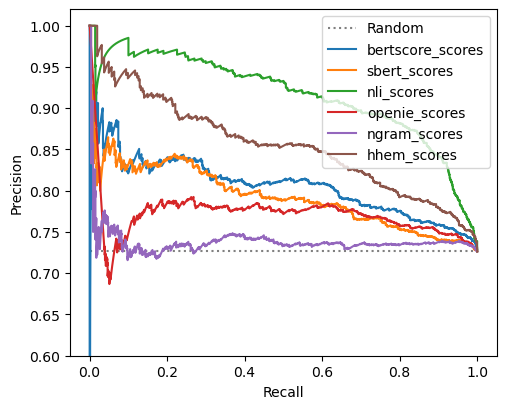

In [14]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='bertscore_scores')
plt.plot(Rb2, Pb2, '-', label='sbert_scores')
plt.plot(Rb3, Pb3, '-', label='nli_scores')
plt.plot(Rb4, Pb4, '-', label='openie_scores')
plt.plot(Rb5, Pb5, '-', label='ngram_scores')
plt.plot(Rb6, Pb6, '-', label='hhem_scores')
plt.legend()
plt.ylim(0.6,1.02)
plt.ylabel("Precision")
plt.xlabel("Recall")

## 2. Experiment2: Detect False* (harder/less-trivial)

In [15]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(bertscore_scores, human_label_detect_False_h, pos_label=1)
Pb2, Rb2 = get_PR_with_human_labels(sbert_scores, human_label_detect_False_h, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(nli_scores, human_label_detect_False_h, pos_label=1)
Pb4, Rb4 = get_PR_with_human_labels(openie_scores, human_label_detect_False_h, pos_label=1)
Pb5, Rb5 = get_PR_with_human_labels(ngram_scores, human_label_detect_False_h, pos_label=1)
Pb6, Rb6 = get_PR_with_human_labels(hhem_scores, human_label_detect_False_h, pos_label=1)
print("bertscore_scores")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("sbert_scores")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("nli_scores")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("openie_scores")
print_AUC(Pb4, Rb4)
print("-----------------------")
print("ngram_scores")
print_AUC(Pb5, Rb5)
print("-----------------------")
print("hhem_scores")
print_AUC(Pb6, Rb6)
print("-----------------------")

len: 1577
len: 1577
len: 1577
len: 1577
len: 1577
len: 1577
bertscore_scores
AUC: 42.53
-----------------------
sbert_scores
AUC: 40.27
-----------------------
nli_scores
AUC: 41.98
-----------------------
openie_scores
AUC: 35.21
-----------------------
ngram_scores
AUC: 29.46
-----------------------
hhem_scores
AUC: 33.79
-----------------------


In [16]:
arr = []
for v in human_label_detect_False_h.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.29296131896005073

Text(0.5, 0, 'Recall')

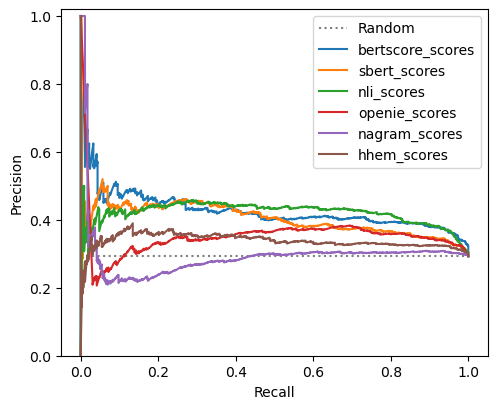

In [17]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='bertscore_scores')
plt.plot(Rb2, Pb2, '-', label='sbert_scores')
plt.plot(Rb3, Pb3, '-', label='nli_scores')
plt.plot(Rb4, Pb4, '-', label='openie_scores')
plt.plot(Rb5, Pb5, '-', label='nagram_scores')
plt.plot(Rb6, Pb6, '-', label='hhem_scores')
plt.legend()
plt.ylim(0.0,1.02)
plt.ylabel("Precision")
plt.xlabel("Recall")

# Experiment3: Detecting True

In [18]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(bertscore_scores, human_label_detect_True, pos_label=1)
Pb2, Rb2 = get_PR_with_human_labels(sbert_scores, human_label_detect_True, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(nli_scores, human_label_detect_True, pos_label=1)
Pb4, Rb4 = get_PR_with_human_labels(openie_scores, human_label_detect_True, pos_label=1)
Pb5, Rb5 = get_PR_with_human_labels(ngram_scores, human_label_detect_True, pos_label=1)
Pb6, Rb6 = get_PR_with_human_labels(hhem_scores, human_label_detect_True, pos_label=1)

print("bertscore_scores")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("sbert_scores")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("nli_scores")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("openie_scores")
print_AUC(Pb4, Rb4)
print("-----------------------")
print("ngram_scores")
print_AUC(Pb5, Rb5)
print("-----------------------")
print("hhem_scores")
print_AUC(Pb6, Rb6)
print("-----------------------")

len: 1843
len: 1843
len: 1843
len: 1843
len: 1843
len: 1843
bertscore_scores
AUC: 21.31
-----------------------
sbert_scores
AUC: 22.06
-----------------------
nli_scores
AUC: 16.61
-----------------------
openie_scores
AUC: 25.21
-----------------------
ngram_scores
AUC: 26.29
-----------------------
hhem_scores
AUC: 18.83
-----------------------


In [19]:
arr = []
for v in human_label_detect_True.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.2734671730873576

Text(0.5, 0, 'Recall')

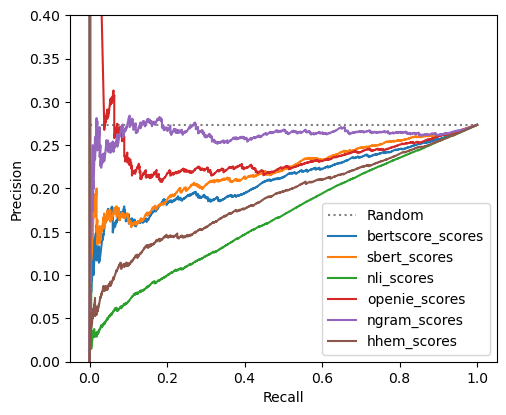

In [21]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='bertscore_scores')
plt.plot(Rb2, Pb2, '-', label='sbert_scores')
plt.plot(Rb3, Pb3, '-', label='nli_scores')
plt.plot(Rb4, Pb4, '-', label='openie_scores')
plt.plot(Rb5, Pb5, '-', label='ngram_scores')
plt.plot(Rb6, Pb6, '-', label='hhem_scores')
plt.legend()
plt.ylim(0.0,0.4)
plt.ylabel("Precision")
plt.xlabel("Recall")

# PCC 계산

In [22]:
def get_selfcheck_passage_score_list(data):
    averages = {key: np.mean(values) for key, values in data.items()}
    sorted_averages = [averages[key] for key in sorted(averages)]
    return sorted_averages
#
def get_human_passage_score_list(input_dict):
    # 키를 정렬하고, 정렬된 키에 해당하는 값을 리스트로 추출
    sorted_values = [input_dict[key] for key in sorted(input_dict)]
    return sorted_values

def plot_scatter_and_regression(selfcheck_method_name, selfcheck_passage_scores):
    plt.scatter(human_passage_scores, selfcheck_passage_scores, alpha=0.5, color='gray')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(human_passage_scores, selfcheck_passage_scores)
    # 회귀 직선의 기울기와 절편, 상관 계수, p-값, 표준 오차 등
    line_x = np.array([min(human_passage_scores), max(human_passage_scores)])
    line_y = slope * line_x + intercept
    plt.plot(line_x, line_y, 'r-', label=f'y={slope:.2f}x+{intercept:.2f}')

    plt.title(f'Scatter Plot with Regression Line for {selfcheck_method_name}')
    plt.xlabel('Human Score (0=Factual, +1=Non-Factual)')
    plt.ylabel('Method Score')
    plt.legend()
    
    plt.show()

In [23]:
human_passage_scores = get_human_passage_score_list(passage_human_label_detect_scores)
bertscore_passage_scores = get_selfcheck_passage_score_list(bertscore_scores)
sbert_passage_scores=get_selfcheck_passage_score_list(sbert_scores)
nli_passage_scores = get_selfcheck_passage_score_list(nli_scores)
openie_passage_scores=get_selfcheck_passage_score_list(openie_scores)
ngram_passage_scores=get_selfcheck_passage_score_list(ngram_scores)
hhem_passage_scores=get_selfcheck_passage_score_list(hhem_scores)


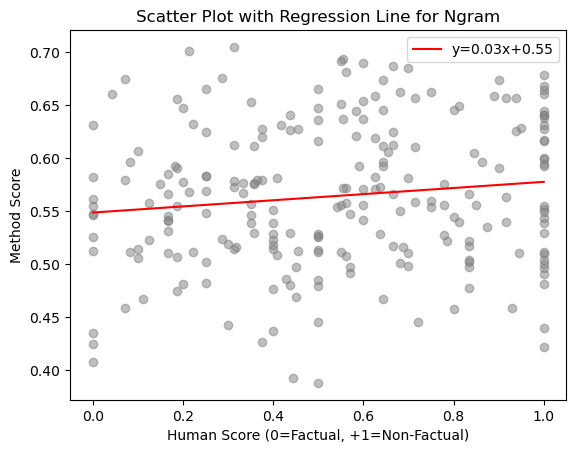

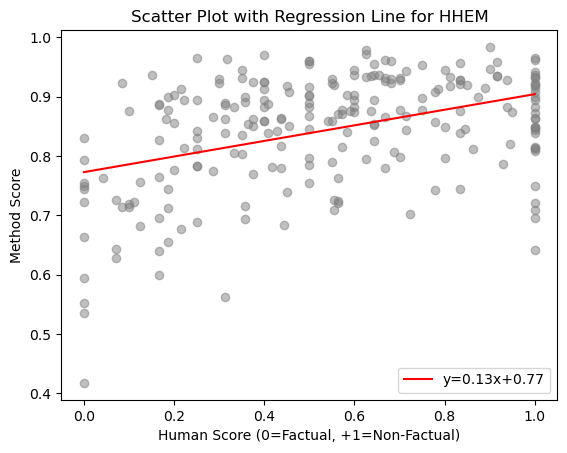

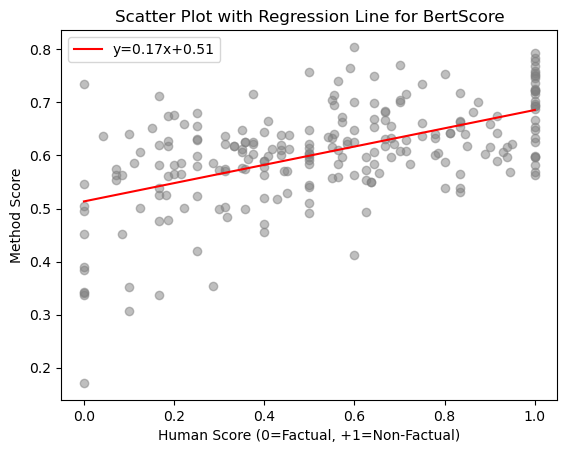

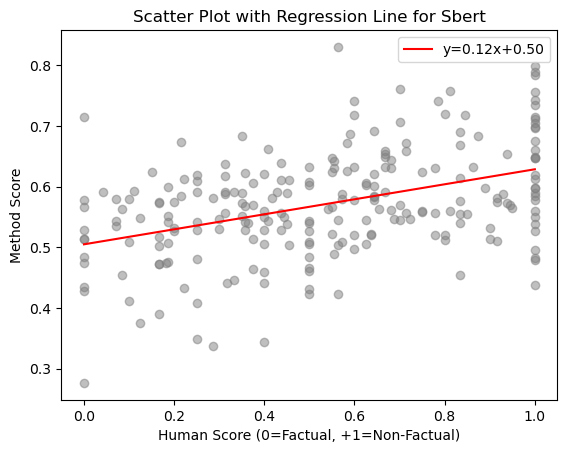

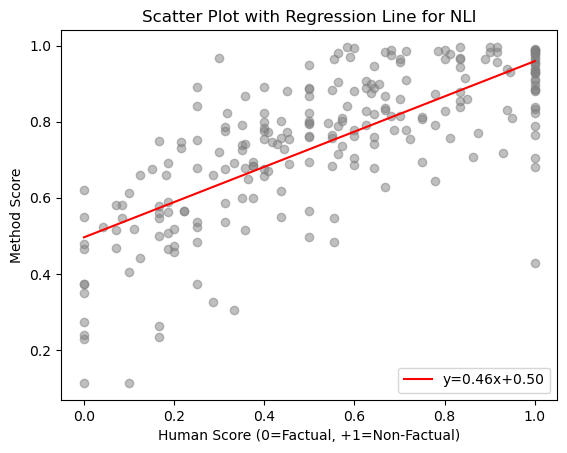

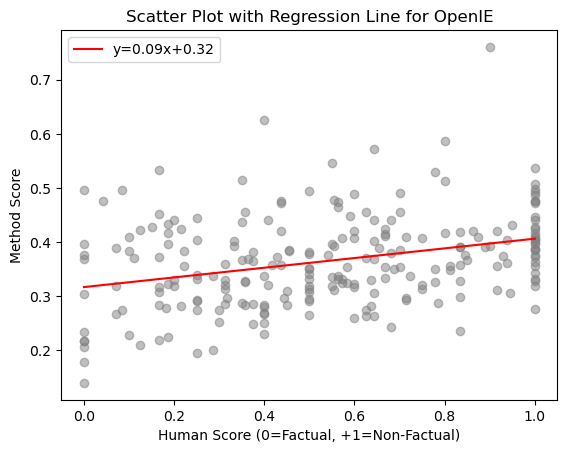

In [24]:
# 함수 호출 예시
plot_scatter_and_regression('Ngram', ngram_passage_scores)
plot_scatter_and_regression('HHEM', hhem_passage_scores)
plot_scatter_and_regression('BertScore', bertscore_passage_scores)
plot_scatter_and_regression('Sbert', sbert_passage_scores)
plot_scatter_and_regression('NLI', nli_passage_scores)
plot_scatter_and_regression('OpenIE', openie_passage_scores)